<a href="https://colab.research.google.com/github/rtajeong/2025_machine_learning_class/blob/main/Handson_02_end_to_end_machine_learning_project_rev7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab assignment for Machine Learning Class
- from chapter 2 of the textbook, "Hands on Machine Learning 2nd edition)" from O'reilly.
- *The task is to predict median house values in Californian districts, given a number of features from these districts.*
- rev5 (2025-09-02)

# Setup

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures (setup current rcParams)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Get the data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import urllib.request
import tarfile
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
import urllib.request
url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz"
urllib.request.urlretrieve(url, "housing.tgz")   # save in a file

('housing.tgz', <http.client.HTTPMessage at 0x7ddfa91f8fe0>)

In [ ]:
import tarfile
tar = tarfile.open("housing.tgz")
tar.extractall()
tar.close()

/tmp/ipython-input-1411139447.py:3: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


In [ ]:
!head -10 housing.csv

longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.12,241400.0,NEAR BAY
-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY


In [ ]:
housing = pd.read_csv("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


- each row represents one district

In [ ]:
housing.shape

(20640, 10)

In [ ]:
housing.columns, housing.index

(Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
        'median_house_value', 'ocean_proximity'],
       dtype='object'),
 RangeIndex(start=0, stop=20640, step=1))

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


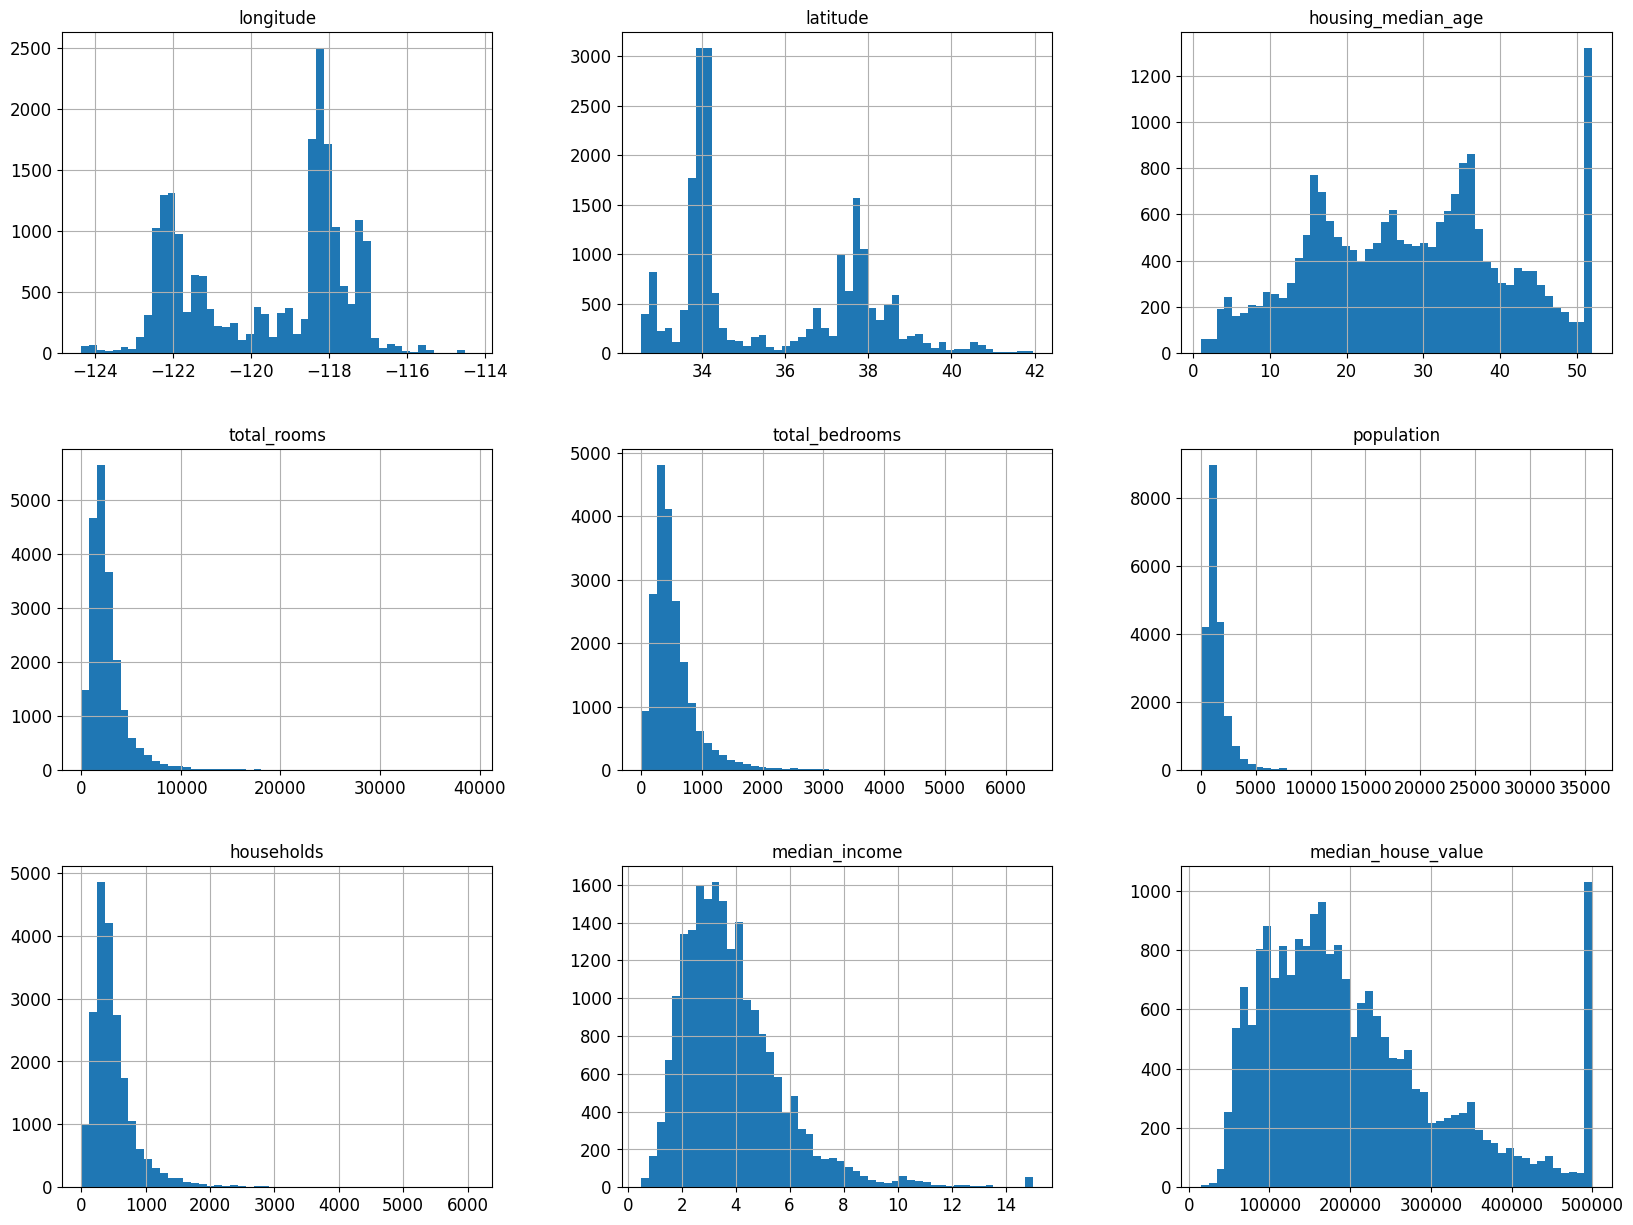

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

- Notice that:
    - median income: not expressed in USD (scaled and capped at 15 for higher and 0.5 for lower. (number actually represents tens of thounds of dollars)
    - the housing median age and the median house value are also capped (if you need precise prediction beyond 15,000 USD, you will have to either collect proper labeled data or remove cropped ones from traing and test dataset.)
    - these attributes have very different scales (need scaling)
    - many histograms are tail-heavy (may make it harder to detect patterns (may need transformation)

In [ ]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
train_set.shape, test_set.shape

((16512, 10), (4128, 10))

In [ ]:
test_set.sample(n=3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
3752,-118.38,34.17,33.0,1588.0,454.0,739.0,392.0,2.8208,238500.0,<1H OCEAN
16705,-120.52,35.06,11.0,1317.0,234.0,655.0,243.0,4.3611,329700.0,<1H OCEAN
2915,-119.06,35.36,9.0,1228.0,234.0,409.0,212.0,4.3482,95200.0,INLAND


- Now, we assume median income is a very important attribute to predict median housing prices.
- We create a new category (income) with 5 categories for Startified Sampling.

<Axes: >

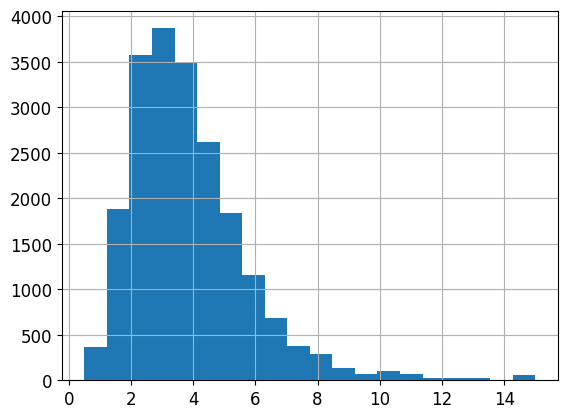

In [ ]:
housing["median_income"].hist(bins=20)

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [ ]:
housing["income_cat"].value_counts()

,count
income_cat,
3,7236
2,6581
4,3639
5,2362
1,822


<Axes: >

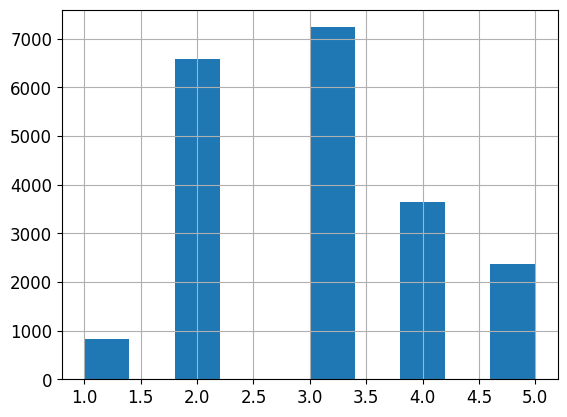

In [ ]:
housing["income_cat"].hist()

- StratifiedShuffleSplit():
  - Stratified ShuffleSplit cross-validator
  - Provides train/test indices to split data in train/test sets.
  - a merge of StratifiedKFold and ShuffleSplit

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):  # use "income_cat" as y for splitting
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    # break   # if you want to use the first split

In [ ]:
strat_train_set.shape, strat_test_set.shape, housing.shape

((16512, 11), (4128, 11), (20640, 11))

In [ ]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [ ]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

,count
income_cat,
3,0.350594
2,0.318859
4,0.176296
5,0.114462
1,0.039789


In [ ]:
housing["income_cat"].value_counts() / len(housing)  # 전체에서 비율

,count
income_cat,
3,0.350581
2,0.318847
4,0.176308
5,0.114438
1,0.039826


In [ ]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

random_train_set, random_test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(random_test_set),
}).sort_index()

In [ ]:
income_cat_proportions(housing)

,count
income_cat,
3,0.350581
2,0.318847
4,0.176308
5,0.114438
1,0.039826


In [ ]:
compare_props

,Overall,Stratified,Random
income_cat,,,
1,0.039826,0.039971,0.040213
2,0.318847,0.318798,0.324370
3,0.350581,0.350533,0.358527
4,0.176308,0.176357,0.167393
5,0.114438,0.114341,0.109496


- as you can see, the test set generated using startified sampling has income category proportions almost identical to those in the full dataset.

In [ ]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


In [ ]:
strat_train_set.drop("income_cat", axis=1, inplace=True)
strat_test_set.drop("income_cat", axis=1, inplace=True)

In [ ]:
strat_train_set.shape, strat_test_set.shape

((16512, 10), (4128, 10))

# Discover and visualize the data to gain insights (data exploration and analysis)

In [ ]:
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

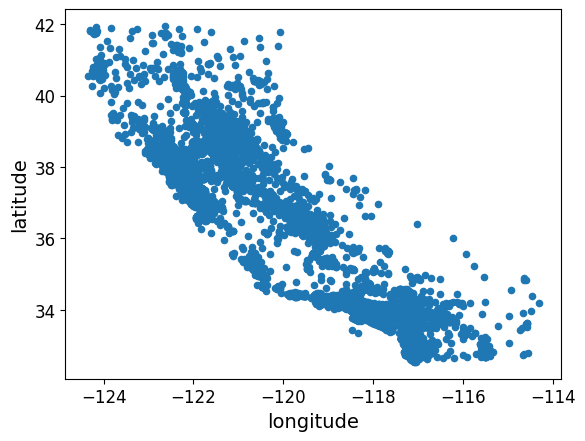

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude")

<Axes: xlabel='longitude', ylabel='latitude'>

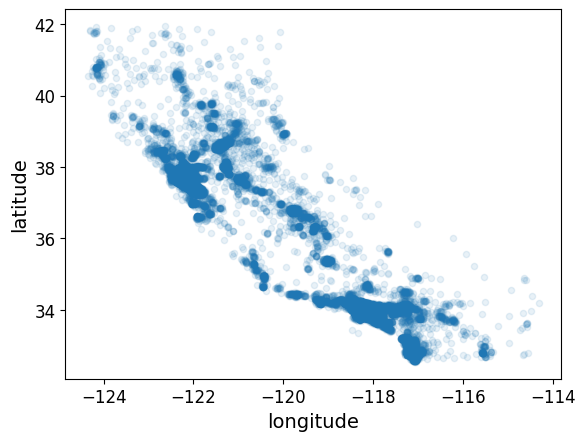

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

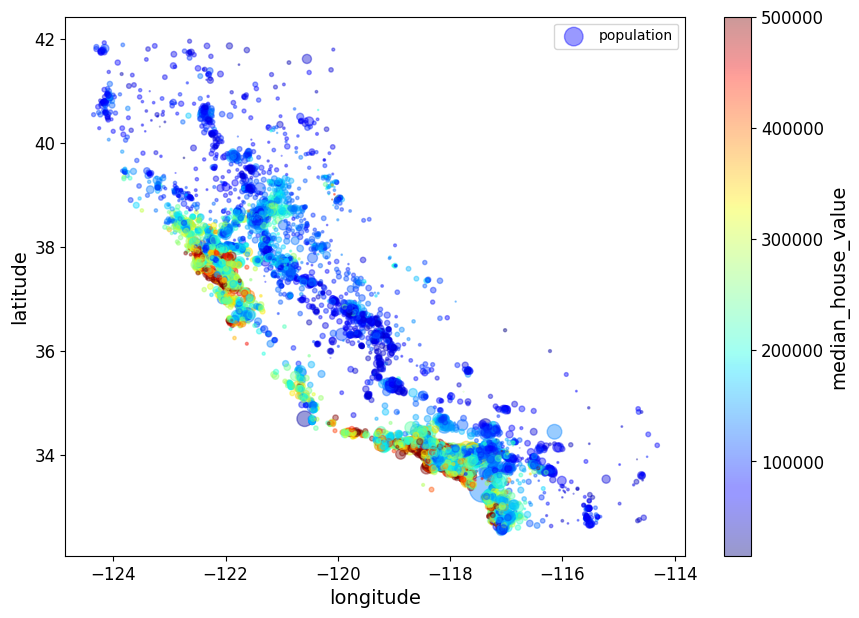

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

- radius of each circle: district's population (option s)
- color: price (option c)
- we can see the house prices are very much related to the loation and to the population density.

In [ ]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7f6a83ef8740>)

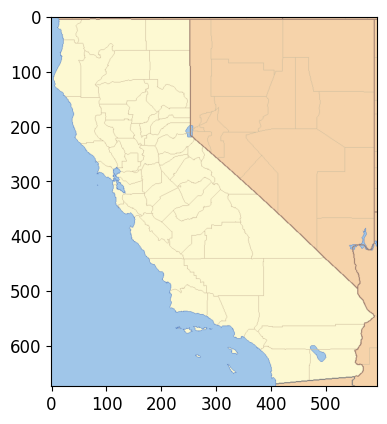

In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread(os.path.join(images_path, filename))
plt.imshow(img)
plt.show()

In [ ]:
housing['latitude'].max(), housing['latitude'].min()

(41.95, 32.54)

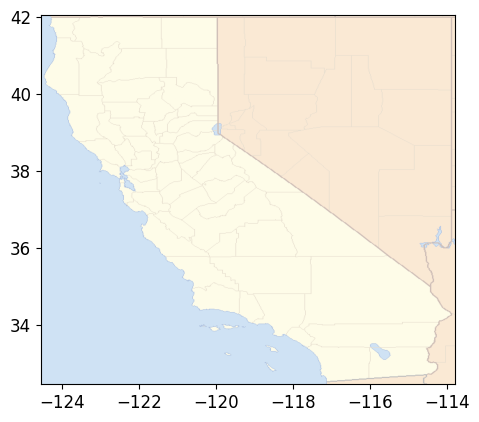

In [ ]:
plt.imshow(img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.show()

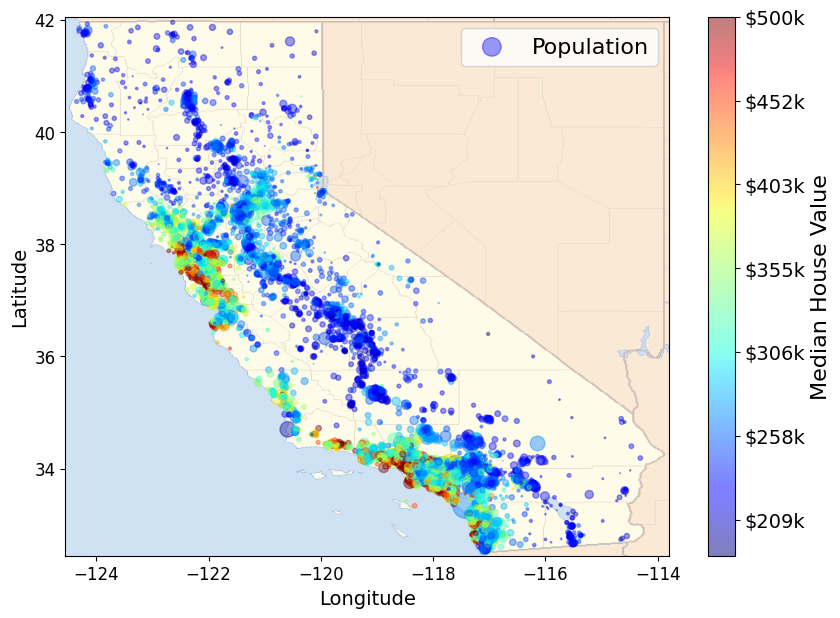

In [ ]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

In [ ]:
housing.dtypes

,0
longitude,float64
latitude,float64
housing_median_age,float64
total_rooms,float64
total_bedrooms,float64
population,float64
households,float64
median_income,float64
median_house_value,float64
ocean_proximity,object


In [ ]:
corr_matrix = housing.select_dtypes(include=['number']).corr()  # only on numerical features
                                                                # or, (exclude=['object'])

In [ ]:
corr_matrix.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781


In [ ]:
corr_matrix.sort_values(by="median_house_value", ascending=False)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673


- or

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.687151
total_rooms,0.135140
housing_median_age,0.114146
households,0.064590
total_bedrooms,0.047781
population,-0.026882
longitude,-0.047466
latitude,-0.142673


- it measures only linear correlations for numerical features
  - The value shows **how good the correlation is** (not how steep the line is), and if it is positive or negative.
  - is not good at curves (correlation only works properly for straight line relationships.)
- You may want to see **pair-wise scatter graphs** to see relationship that the correlation does not.

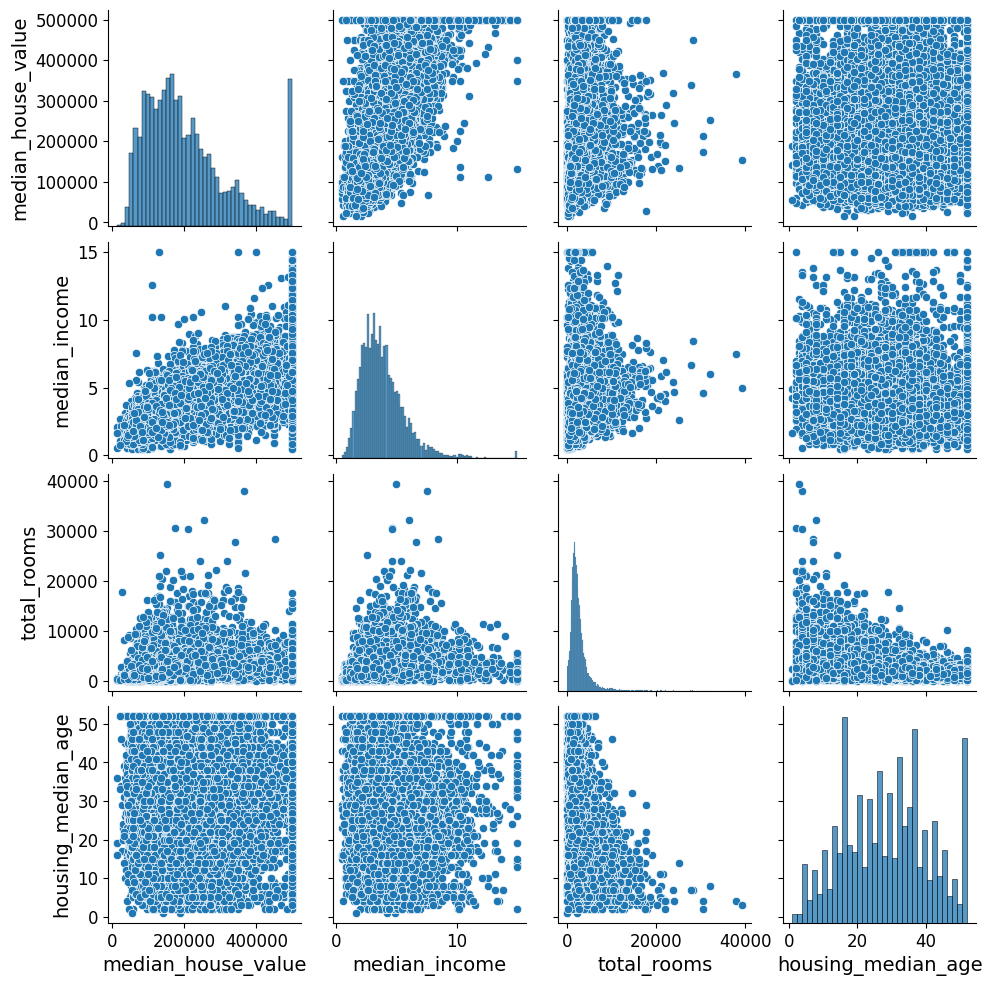

In [ ]:
import seaborn as sns

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
sns.pairplot(housing[attributes])

- seems that the most promising attribute to predict the medium house value is the medium income

Saving figure income_vs_house_value_scatterplot


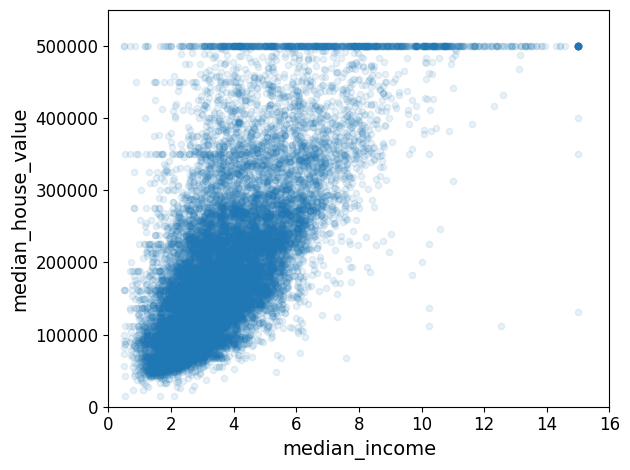

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

- now we see:
    - very strong correlation
    - price cap at 500,000 usd (horizantal line)
    - also few more straight lines around 450, 350, 280 K-USD

- seems that we can make more meaningful attributes, such as

In [ ]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [ ]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [ ]:
corr_matrix = housing.select_dtypes(include=['number']).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.687151
rooms_per_household,0.146255
total_rooms,0.135140
housing_median_age,0.114146
households,0.064590
total_bedrooms,0.047781
population_per_household,-0.021991
population,-0.026882
longitude,-0.047466


- we see that
   - new attributes (rooms_per_household, bedrooms_per_room) are more informative

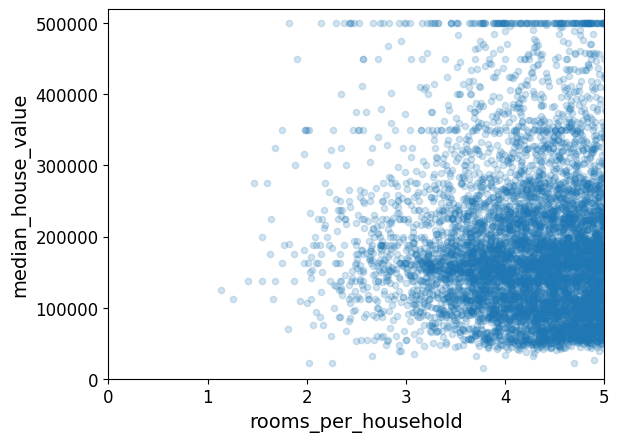

In [ ]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,5.440406,0.212873,3.096469
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,2.611696,0.057378,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,4.442168,0.175304,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,5.232342,0.203027,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,6.056361,0.239816,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Prepare the data for Machine Learning algorithms (Cleaning and transform)

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop the label for training set
housing_labels = strat_train_set["median_house_value"].copy() # original data 를 지키기 위해 copy()

In [ ]:
housing.isnull().any(axis=0)

,0
longitude,False
latitude,False
housing_median_age,False
total_rooms,False
total_bedrooms,True
population,False
households,False
median_income,False
ocean_proximity,False


In [ ]:
housing['total_bedrooms'].isnull().sum()

np.int64(158)

- we have options:

   - option 1: remove the samples that have null
   - option 2: remove the attribute (total_bedroom)
   - option 3: replace NaN's with the mean or median value


In [ ]:
# Let's try an example with a small set
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [ ]:
# option 1
sample_incomplete_rows.dropna(subset=["total_bedrooms"]).head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [ ]:
# option 2
sample_incomplete_rows.drop("total_bedrooms", axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


In [ ]:
# option 3
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)
sample_incomplete_rows

/tmp/ipython-input-4034488351.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


- when choosing option 3:
  - should save the median value. You will need it later to replace NaN in the testing set, and also once the system goes live.

- Scikit-learn provides SimpleImputer to take care of all these.

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [ ]:
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [ ]:
imputer.fit(housing_num)
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Check that this is the same as manually computing the median of each attribute:

In [ ]:
housing.select_dtypes(exclude='object').median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Transform the training set:

In [ ]:
X = imputer.transform(housing_num)    # array

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)

In [ ]:
sample_incomplete_rows.index.values

array([ 1606, 10915, 19150,  4186, 16885])

In [ ]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


In [ ]:
imputer.strategy

'median'

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [ ]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


Now let's preprocess the categorical input feature, `ocean_proximity`:

In [ ]:
strat_test_set["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,1859
INLAND,1289
NEAR OCEAN,534
NEAR BAY,443
ISLAND,3


In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.value_counts()

,count
ocean_proximity,
<1H OCEAN,7277
INLAND,5262
NEAR OCEAN,2124
NEAR BAY,1847
ISLAND,2


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [ ]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Let's create a custom transformer to add extra attributes:
- rooms_per_household = total_rooms/households
- bedrooms_per_room = total_bedrooms/total_rooms
- population_per_household = population/households

In [ ]:
# to see columns by numbers (index numbers)
housing.columns, housing.columns.get_loc('total_rooms')

(Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
        'ocean_proximity'],
       dtype='object'),
 3)

In [ ]:
# from sklearn.base import BaseEstimator, TransformerMixin

col_names = ["total_rooms", "total_bedrooms", "population", "households"]
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

In [ ]:
rooms_ix, bedrooms_ix, population_ix, households_ix

(3, 4, 5, 6)

- BaseEstimator: base class for all estimators in scikit-learn (has get_params() and set_params(**params))
- TransformerMixin: mixin class for all transformers in scikit-learn(has fit_transform(X))

In [ ]:
# fit_transform() is inherited from TransformerMixin().
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]

        X = np.delete(X, [households_ix, rooms_ix, population_ix, bedrooms_ix], 1)

        return np.c_[X, rooms_per_household, population_per_household,
                    bedrooms_per_room]

attr_adder = CombinedAttributesAdder()
housing_extra_attribs = attr_adder.transform(housing_tr.values)

In [ ]:
housing_extra_attribs.shape, housing_tr.shape

((16512, 7), (16512, 8))

Also, housing_extra_attribs is a NumPy array, we've lost the column names (unfortunately, that's a problem with Scikit-Learn). To recover a DataFrame, you could run this:

In [ ]:
col_names

['total_rooms', 'total_bedrooms', 'population', 'households']

In [ ]:
list(housing_tr.columns)

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [ ]:
new_cols = [elem for elem in list(housing_tr.columns) if elem not in col_names]
new_cols

['longitude', 'latitude', 'housing_median_age', 'median_income']

In [ ]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


In [ ]:
housing_extra_attribs.shape, housing_tr.columns

((16512, 7),
 Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income'],
       dtype='object'))

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=new_cols + ["rooms_per_household", "population_per_household", "bedrooms_per_room"],
    index=housing_tr.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,median_income,rooms_per_household,population_per_household,bedrooms_per_room
12655,-121.46,38.52,29.0,2.1736,5.485836,3.168555,0.205784
15502,-117.23,33.09,7.0,6.3373,6.927083,2.623698,0.160714
2908,-119.04,35.37,44.0,2.8750,5.393333,2.223333,0.191595
14053,-117.13,32.75,24.0,2.2264,3.886128,1.859213,0.276505
20496,-118.70,34.28,27.0,4.4964,6.096552,3.167241,0.182692


Now let's build a pipeline for preprocessing the numerical attributes:
- Pipeline():
  - internal tranformers + final estimator
  - perform fit() and transform() for all internal transformers (or fit_transform())
  - perform fit() for the final estimator


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

- ColumnTransformer: Applies transformers to columns of an array or pandas DataFrame.

In [ ]:
list(housing_num)

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
housing_prepared.shape

(16512, 12)

# Select and train a model

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [ ]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 88272.7645308  300375.54960938 140377.96235063 171432.12995958
 247659.05586413]


Compare against the actual values:

In [ ]:
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [ ]:
some_data_prepared

array([[-0.94135046,  1.34743822,  0.02756357, -0.8936472 ,  0.01739526,
         0.00622264, -0.12112176,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763,  1.292168  ,  0.56925554,
        -0.04081077, -0.81086696,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, -0.52543365, -0.01802432,
        -0.07537122, -0.33827252,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ],
       [ 1.22173797, -1.35147437, -0.37006852, -0.86592882, -0.59513997,
        -0.10680295,  0.96120521,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [ 0.43743108, -0.63581817, -0.13148926,  0.32575178,  0.2512412 ,
         0.00610923, -0.47451338,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_r2 = r2_score(housing_labels, housing_predictions)
lin_mse, np.sqrt(lin_mse), lin_r2, lin_reg.score(housing_prepared, housing_labels)

(5147540045.340924,
 np.float64(71746.35910860512),
 0.6154528652254023,
 0.6154528652254023)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42, max_depth=20)   # max_depth
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_r2 = r2_score(housing_labels, housing_predictions)
tree_mse, np.sqrt(tree_mse), tree_r2, tree_reg.score(housing_prepared, housing_labels)

(107542556.3513253,
 np.float64(10370.272723092932),
 0.9919660300751485,
 0.9919660300751485)

In [ ]:
# performance evaluation on Test dataset
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = tree_reg.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_mse, np.sqrt(final_mse), tree_reg.score(X_test_prepared, y_test)

(4766107525.503113, np.float64(69037.00113347272), 0.6343088607835374)

In [ ]:
lin_reg.score(X_test_prepared, y_test), tree_reg.score(X_test_prepared, y_test)

(0.6232555741249366, 0.6343088607835374)

# Fine-tune your model

- All scorer objects follow the convention that higher return values are better than lower return values.
- So, use neg_mean_squared_error rather than mean_squared_error.

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [69627.76297598 68112.58708499 64542.98883232 70606.62212567
 70767.11684135 74460.40276922 73235.70675299 70647.24513941
 70259.93929741 70059.66135187]
Mean: 70232.0033171216
Standard deviation: 2544.66318593927


In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [73828.08428563 67928.54072384 67252.48799783 73689.83992107
 70353.65855082 75311.79184271 77813.41336667 71233.51732128
 69906.5610527  72997.95099077]
Mean: 72031.58460533175
Standard deviation: 3142.3429943397573


In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

np.float64(18521.37469601513)

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51229.42010343 48994.01119524 46558.00798219 51481.94679064
 47050.94787163 50838.24323513 51897.6153813  49704.52541974
 48655.11499315 53551.37435042]
Mean: 49996.12073228607
Standard deviation: 2099.4188986050785


In [ ]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

,0
count,10.000000
mean,72031.584605
std,3312.320351
min,67252.487998
25%,70018.335427
50%,72115.734156
75%,73793.523194
max,77813.413367


In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

np.float64(111397.82633920867)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30],
     'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False],
     'n_estimators': [3, 10],
     'max_features': [2, 3, 4]},
  ]
# If bootstrap=False, the whole dataset is used to build each tree.

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

The best hyperparameter combination found:

In [ ]:
grid_search.best_params_

{'max_features': 4, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(max_features=4, n_estimators=30, random_state=42)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

59244.051515797524 {'max_features': 2, 'n_estimators': 3}
51606.17845666218 {'max_features': 2, 'n_estimators': 10}
49130.08627957421 {'max_features': 2, 'n_estimators': 30}
58459.416807983034 {'max_features': 4, 'n_estimators': 3}
51033.73158631013 {'max_features': 4, 'n_estimators': 10}
49047.225210908604 {'max_features': 4, 'n_estimators': 30}
57966.76523213554 {'max_features': 6, 'n_estimators': 3}
51498.93958254157 {'max_features': 6, 'n_estimators': 10}
49329.607776112316 {'max_features': 6, 'n_estimators': 30}
58674.94286563425 {'max_features': 8, 'n_estimators': 3}
52126.6847464154 {'max_features': 8, 'n_estimators': 10}
50081.52859471549 {'max_features': 8, 'n_estimators': 30}
57074.864123848674 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
50157.7037751803 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
56936.737195399546 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
50498.70023045981 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [ ]:
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.140256,0.004553,0.006313,0.000226,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.670080e+09,-3.537589e+09,...,-3.509858e+09,1.849578e+08,18,-9.787588e+08,-9.238306e+08,-9.026308e+08,-8.851999e+08,-9.276486e+08,-9.236137e+08,3.153798e+07
1,0.393909,0.058582,0.014177,0.001401,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.750954e+09,-2.577851e+09,...,-2.663198e+09,1.254207e+08,10,-4.952294e+08,-4.967216e+08,-4.831044e+08,-4.947114e+08,-5.083629e+08,-4.956259e+08,8.015131e+06
2,0.952910,0.006157,0.035725,0.000426,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.452074e+09,-2.358536e+09,...,-2.413765e+09,1.226910e+08,2,-3.730743e+08,-3.666074e+08,-3.714940e+08,-3.621189e+08,-3.703386e+08,-3.687267e+08,3.932218e+06
3,0.159243,0.004843,0.005068,0.000141,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.506097e+09,-3.288688e+09,...,-3.417503e+09,1.677456e+08,16,-9.244866e+08,-8.930814e+08,-8.602148e+08,-8.934980e+08,-8.849291e+08,-8.912420e+08,2.057290e+07
4,0.535946,0.012763,0.014575,0.002251,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.598051e+09,-2.513262e+09,...,-2.604442e+09,1.036711e+08,8,-4.665331e+08,-4.863577e+08,-4.788114e+08,-4.776315e+08,-4.943013e+08,-4.807270e+08,9.280990e+06


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d3342b120b0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d333d56c910>},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

48829.83865585141 {'max_features': 7, 'n_estimators': 180}
50550.25006107064 {'max_features': 5, 'n_estimators': 15}
47862.836646156684 {'max_features': 3, 'n_estimators': 72}
49700.24558862216 {'max_features': 5, 'n_estimators': 21}
48865.76430530215 {'max_features': 7, 'n_estimators': 122}
47822.43993272504 {'max_features': 3, 'n_estimators': 75}
47878.59652078871 {'max_features': 3, 'n_estimators': 88}
48474.456786934206 {'max_features': 5, 'n_estimators': 100}
47803.1644087752 {'max_features': 3, 'n_estimators': 150}
62631.18006641175 {'max_features': 5, 'n_estimators': 2}


In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([9.23060698e-02, 8.57068314e-02, 4.79408965e-02, 2.98816345e-01,
       7.11798094e-02, 1.17200477e-01, 1.04500745e-01, 1.34266726e-02,
       1.57413218e-01, 8.89402012e-05, 6.35848106e-03, 5.06151301e-03])

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]

cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.29881634515329364, 'total_rooms'),
 (0.15741321829186802, 'rooms_per_hhold'),
 (0.11720047744811966, 'population'),
 (0.10450074516086487, 'households'),
 (0.09230606980558448, 'longitude'),
 (0.08570683144102773, 'latitude'),
 (0.07117980935234985, 'total_bedrooms'),
 (0.04794089648067517, 'housing_median_age'),
 (0.013426672598557711, 'median_income'),
 (0.006358481060532198, 'bedrooms_per_room'),
 (0.005061513005971311, '<1H OCEAN'),
 (8.89402011553598e-05, 'pop_per_hhold')]

# Evaluate your system on the Test Set

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse, final_model.score(X_test_prepared, y_test)

(np.float64(46764.22302579239), 0.8322053739706845)

We can compute a 95% confidence interval for the test RMSE:

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))  # sem: standard error of the mean

array([44751.2941517 , 48694.01176901])

In [ ]:
squared_errors.shape

(4128,)

We could compute the interval manually like this:

In [ ]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(np.float64(44751.29415169542), np.float64(48694.011769010496))

Alternatively, we could use a z-scores rather than t-scores:
- CI = x_bar + Z_score * (sigma / root(n))

In [ ]:
zscore = stats.norm.ppf((1 + confidence) / 2)   # 0.5 + confidene/2
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(np.float64(44751.897772572855), np.float64(48693.4570159615))

# Additional Work

## A full pipeline with both preparation and prediction

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([ 88272.7645308 , 300375.54960938, 140377.96235063, 171432.12995958,
       247659.05586413])

## Model persistence using joblib
- joblib: running Python functions as pipeline jobs
- we also have 'pickle' library
- in fact, joblib is built on top of pickle.

In [ ]:
my_model = full_pipeline_with_predictor

import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

# Altogether

## data preparation and model training

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import urllib.request
import tarfile
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]

        X = np.delete(X, [households_ix, rooms_ix, population_ix, bedrooms_ix], 1)

        return np.c_[X, rooms_per_household, population_per_household,
                    bedrooms_per_room]


# load dataset
url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz"
urllib.request.urlretrieve(url, "housing.tgz")
tar = tarfile.open("housing.tgz")
tar.extractall()
tar.close()
housing_org = pd.read_csv("housing.csv")
housing = housing_org.copy()

# split dataset
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# preprocessing
housing = strat_train_set.drop("median_house_value", axis=1)   # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

col_names = ["total_rooms", "total_bedrooms", "population", "households"]
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

attr_adder = CombinedAttributesAdder()
# housing_extra_attribs = attr_adder.transform(housing.values)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num = housing.drop("ocean_proximity", axis=1)
# housing_num_tr = num_pipeline.fit_transform(housing_num)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

#train
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_r2 = r2_score(housing_labels, housing_predictions)
print("Performance for Train dataset: ", lin_mse, np.sqrt(lin_mse), lin_r2)

# test
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = lin_reg.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
print("Final performance evaluation: ", final_mse, np.sqrt(final_mse), lin_reg.score(X_test_prepared, y_test))


Performance for Train dataset:  5052794622.86234 71083.01219603978 0.6202512396073068
Final performance evaluation:  5318969652.955361 72931.26663479362 0.6017249119839772


/tmp/ipython-input-3122084106.py:35: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


- model save and reload (joblib.dump() and loblib.load())
  - joblib is faster than pickle

In [ ]:
# save the transformer and the model
import joblib

full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
my_model = full_pipeline_with_predictor
joblib.dump(my_model, "my_model.pkl")

['my_model.pkl']

## deployment

In [ ]:
# let's try to predict y^ for some data

sample_data = housing_org.sample(5)
new_X = sample_data.drop("median_house_value", axis=1)  # data
y_for_new_X = sample_data["median_house_value"]

In [ ]:
import joblib

my_model_loaded = joblib.load("my_model.pkl")   # model

predicted = my_model_loaded.predict(new_X)
pd.DataFrame(np.c_[predicted.round(1), y_for_new_X], columns=["predicted", "real_value"])

,predicted,real_value
0,225042.8,228200.0
1,84592.1,60500.0
2,154246.4,118500.0
3,159518.5,115400.0
4,179272.2,187200.0


# Homework Assignment #1
Homework 1: Understanding the Workflow

- Part A: Manually replicate the Pipeline workflow by performing fitting and transforming steps sequentially.

- Part B: Experiment with some new feature engineerings or preprocessing techniques to improve upon the machine learning model's score.

- Performance metric: For this regression task, Root Mean Squared Error (RMSE) is a standard and effective choice.

- [Note] All assignments should be submitted in Notebook code format. (use as much documentation text as possible to explain your code and discuss your experimental result.)


# Exercise

## joblib and pickle
- joblib is known to be faster than pickle. Here, the file size is too small to see the difference.

In [ ]:
#comapare pickle loaders
from time import time
import pickle
import os
import joblib

file = "my_model.pkl"
t1 = time()
d = pickle.load(open(file,"rb"))
print("time for loading file size with pickle", os.path.getsize(file)/1000.,"KB =>", time()-t1)

t1 = time()
joblib.load(file)
print("time for loading file size joblib", os.path.getsize(file)/1000.,"KB =>", time()-t1)

time for loading file size with pickle 4.351 KB => 0.000705718994140625
time for loading file size joblib 4.351 KB => 0.004038333892822266


## few things to note

- 'view' nd 'copy' in pandas (when modifying a subset of dataframe)
  - pandas uses 'view' for data effiiency
  - so, even with the different objects, df and df2 still reference the same underlying data.
  - you can use 'copy()' to avoid this.
- when return 'view'
  - column access: df2 = df['A']
  - slicing rows(df.loc[] and df.iloc[]: df2 = df.loc[:, 'A']
- when return 'copy'
  - indexing multiple columns: df2 = df[['A', 'B']]
  - Operations That Modify Data (apply(), map(): df2 = df[df['A'] > 2]
  - Assigning New Data
- if not clear, use df2 = df.copy()

In [ ]:
df = pd.DataFrame({"A": [1,2,3],
                   "B": [4,5,6]})
print(df)
df2 = df['A']    # df2 will changhe the content of df also.
df2.iloc[0] = 100
print()
print(df2)
print()
print(df)

   A  B
0  1  4
1  2  5
2  3  6

0    100
1      2
2      3
Name: A, dtype: int64

     A  B
0  100  4
1    2  5
2    3  6


In [ ]:
id(df), id(df2)  # different objects

(135367488107760, 135367495102480)

In [ ]:
df3 = df['A'].copy()
df3.iloc[0] = 777
print(df)
print(df3)

     A  B
0  100  4
1    2  5
2    3  6
0    777
1      2
2      3
Name: A, dtype: int64


- StratifiedShuffleSplit is a variation of ShuffleSplit, which returns stratified splits, i.e which creates splits by preserving the same percentage for each target class as in the complete set. (StratifiedKFold + ShuffleSplit)

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2],
              [1, 5], [3, 2], [1, 3], [2, 4], [4, 2]])
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
# print (X, y)
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.4, random_state=0)
sss.get_n_splits(X, y)

2

In [ ]:
print(sss)

StratifiedShuffleSplit(n_splits=2, random_state=0, test_size=0.4,
            train_size=None)


In [ ]:
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [0 5 7 2 1 6] TEST: [4 9 8 3]
TRAIN: [3 7 5 8 0 4] TEST: [2 6 9 1]


- example scipy distributions for RandomizedSearchCV

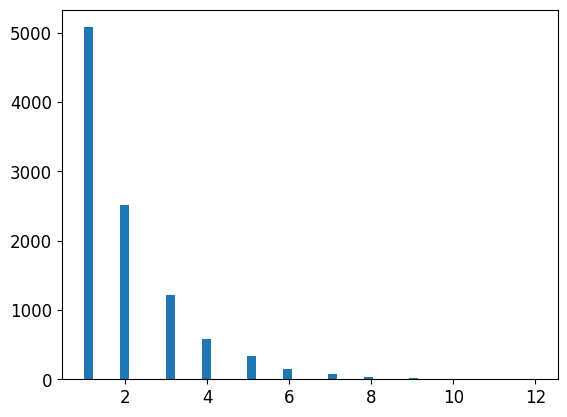

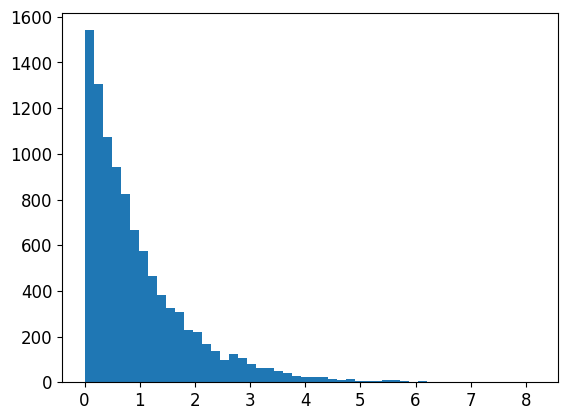

In [ ]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)  # geometric dist.
expon_distrib=expon(scale=1).rvs(10000, random_state=42) # exponential continuous dist. y=exp(-x)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

## Numpy concatenation

Translates slice objects to concatenation along the second axis.

In [ ]:
# np.c_
a, b = np.array([1,2,3]), np.array([4,5,6])

In [ ]:
np.c_[a,b]

array([[1, 4],
       [2, 5],
       [3, 6]])

In [ ]:
np.r_[a,b]

array([1, 2, 3, 4, 5, 6])

In [ ]:
np.concatenate([a,b])

array([1, 2, 3, 4, 5, 6])

In [ ]:
np.column_stack([a,b])

array([[1, 4],
       [2, 5],
       [3, 6]])

In [ ]:
a = np.arange(18).reshape(6,3)
a

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17]])

In [ ]:
x, y = a[:,0]/a[:,2], a[:,1]/a[:,2]
x,y

(array([0.        , 0.6       , 0.75      , 0.81818182, 0.85714286,
        0.88235294]),
 array([0.5       , 0.8       , 0.875     , 0.90909091, 0.92857143,
        0.94117647]))

In [ ]:
np.c_[x, y]

array([[0.        , 0.5       ],
       [0.6       , 0.8       ],
       [0.75      , 0.875     ],
       [0.81818182, 0.90909091],
       [0.85714286, 0.92857143],
       [0.88235294, 0.94117647]])

In [ ]:
np.c_[a, x, y]   # translate slice objects to concatenation  along the second axis

array([[ 0.        ,  1.        ,  2.        ,  0.        ,  0.5       ],
       [ 3.        ,  4.        ,  5.        ,  0.6       ,  0.8       ],
       [ 6.        ,  7.        ,  8.        ,  0.75      ,  0.875     ],
       [ 9.        , 10.        , 11.        ,  0.81818182,  0.90909091],
       [12.        , 13.        , 14.        ,  0.85714286,  0.92857143],
       [15.        , 16.        , 17.        ,  0.88235294,  0.94117647]])

In [ ]:
np.r_[x, y].round(2) # along the first axis

array([0.  , 0.6 , 0.75, 0.82, 0.86, 0.88, 0.5 , 0.8 , 0.88, 0.91, 0.93,
       0.94])

In [ ]:
np.r_[[x], [y]].round(2)

array([[0.  , 0.6 , 0.75, 0.82, 0.86, 0.88],
       [0.5 , 0.8 , 0.88, 0.91, 0.93, 0.94]])

In [ ]:
np.c_[[x], [y]].round(2)

array([[0.  , 0.6 , 0.75, 0.82, 0.86, 0.88, 0.5 , 0.8 , 0.88, 0.91, 0.93,
        0.94]])

## StratifiesShuffleSplit

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
Data = np.array([[1, 2, 0],
                 [3, 4, 0],
                 [1, 2, 1],
                 [3, 4, 1],
                 [2, 3, 2],
                 [3, 4, 2]])
X, y = Data[:,:-1], Data[:, -1]
X, y

(array([[1, 2],
        [3, 4],
        [1, 2],
        [3, 4],
        [2, 3],
        [3, 4]]),
 array([0, 0, 1, 1, 2, 2]))

In [ ]:
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.5, random_state=0)
sss

StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.5,
            train_size=None)

In [ ]:
for train_index, test_index in sss.split(X, y):
     print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]

TRAIN: [4 2 1] TEST: [0 5 3]
TRAIN: [3 0 5] TEST: [2 4 1]
TRAIN: [2 1 5] TEST: [0 4 3]


- We cqan see that the y-values are evenly distributed between the training and test sets.

## Pipeline

- Pipeline:
  - Sequentially apply a list of transforms and a final estimator.
  - Intermediate steps of the pipeline must be **transform**, that is, they must implement **fit and transform** methods.
  - The final estimator only needs to implement **fit**.
  - The transformers in the pipeline can be cached using memory argument.
  - get (key, value) pairs:the *key* is a name and and *value* is an estimator object.

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [ ]:
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape, X_test.shape)
pipe = Pipeline([('scaler', StandardScaler()),
                 ('svc', SVC())])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test), pipe.score(X_train, y_train)

(75, 20) (25, 20)


(0.88, 0.96)

In [ ]:
# train
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
svc = SVC()
svc.fit(X_train, y_train)
# test
X_test = sc.transform(X_test)
svc.score(X_test, y_test), svc.score(X_train, y_train)

(0.88, 0.96)

In [ ]:
pipe

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])

In [ ]:
pipe.steps[0], pipe[0]

(('scaler', StandardScaler()), StandardScaler())

In [ ]:
pipe[-1:],  pipe[-1]

(Pipeline(steps=[('svc', SVC())]), SVC())

## ColumnTransformer

- ColumnTransformer
  - The ColumnTransformer helps performing different transformations for different columns of the data, within a Pipeline that is safe from data leakage and that can be parametrized.
  - ColumnTransformer works on arrays, sparse matrices, and pandas DataFrames.
  - estimatros (inside transformers) must support *fit* and *transform*.

In [ ]:
import pandas as pd
X = pd.DataFrame(
     {'city': ['London', 'London', 'Paris', 'Moscow'],
      'title': ["His Last Bow", "How Watson Learned the Trick",
                "A Moveable Feast", "The Grapes of Wrath"],
      'avg_sales': [270.3, 370.2, 458.1, 397.4],
      'avg_miles': [14.2, 24.1, 15.2, 20.7]})
X

,city,title,avg_sales,avg_miles
0,London,His Last Bow,270.3,14.2
1,London,How Watson Learned the Trick,370.2,24.1
2,Paris,A Moveable Feast,458.1,15.2
3,Moscow,The Grapes of Wrath,397.4,20.7


- (continued)
  - Suppose we want to use Onehotencoder for the column 'city', and CountVectorizer for 'title'

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

column_trans = ColumnTransformer(
    [('city_category', OneHotEncoder(dtype='int'),['city']),
     ('title_bow', CountVectorizer(), 'title'),
     # ('numeric_features', StandardScaler(), ['avg_sales', 'avg_miles'])
     ], remainder='drop')           # remaining columns

In [ ]:
column_trans

ColumnTransformer(transformers=[('city_category', OneHotEncoder(dtype='int'),
                                 ['city']),
                                ('title_bow', CountVectorizer(), 'title')])

In [ ]:
column_trans.fit(X)

ColumnTransformer(transformers=[('city_category', OneHotEncoder(dtype='int'),
                                 ['city']),
                                ('title_bow', CountVectorizer(), 'title')])

In [ ]:
column_trans.transform(X).toarray()

array([[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]])

In [ ]:
# column_trans.fit_transform(X)
column_trans.fit_transform(X).toarray()

array([[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]])

In [ ]:
# column_trans.transform(X)[:2]
column_trans.transform(X)[:2].toarray()

array([[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]])

In [ ]:
column_trans.get_feature_names_out()

array(['city_category__city_London', 'city_category__city_Moscow',
       'city_category__city_Paris', 'title_bow__bow', 'title_bow__feast',
       'title_bow__grapes', 'title_bow__his', 'title_bow__how',
       'title_bow__last', 'title_bow__learned', 'title_bow__moveable',
       'title_bow__of', 'title_bow__the', 'title_bow__trick',
       'title_bow__watson', 'title_bow__wrath'], dtype=object)

## joblib and pickle
- joblib is faster than pickle

In [ ]:
#comapare pickle loaders
from time import time
import pickle
import os
import _pickle as cPickle
import joblib

file = os.path.join(os.path.dirname(os.path.realpath(__file__)), 'database.clf')
t1 = time()
lis = []
d = pickle.load(open(file,"rb"))
print("time for loading file size with pickle", os.path.getsize(file),"KB =>", time()-t1)

t1 = time()
cPickle.load(open(file,"rb"))
print("time for loading file size with cpickle", os.path.getsize(file),"KB =>", time()-t1)

t1 = time()
joblib.load(file)
print("time for loading file size joblib", os.path.getsize(file),"KB =>", time()-t1)

NameError: name '__file__' is not defined

## t-distribution

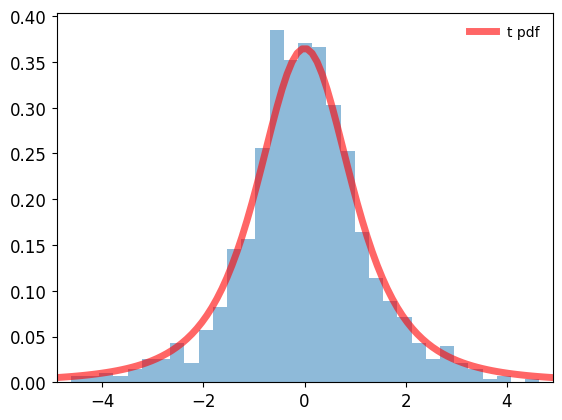

In [ ]:
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
df = 2.74

# t-dist pdf
mean, var, skew, kurt = t.stats(df, moments='mvsk')     # mean, variance, skew, kurtosis
x = np.linspace(t.ppf(0.01, df), t.ppf(0.99, df), 100)  # percent point function
ax.plot(x, t.pdf(x, df), 'r-', lw=5, alpha=0.6, label='t pdf')

# random t-dist samples
r = t.rvs(df, size=1000)  # generate random numbers
ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.5)
ax.set_xlim([x[0], x[-1]])
ax.legend(loc='best', frameon=False)

plt.show()

## t-interval
- A confidence interval is a way of using a sample to estimate an unknown population value.
- (to estimate an unknown population mean)
- For estimating the mean, there are two types of confidence intervals that can be used:
  - z-interval: when population standard deviation is **KNOWN** and (population is normal OR sample size >= 30)
  - t-interval: when population standard deviation is **UNKNOWN** and (population is normal OR sample size < 30)

In [ ]:
## sample size < 30 ,so use t-distribution to calculate the confidence interval

import numpy as np
import scipy.stats as st

data = np.array([87,80,68,72,56,58,60,63,82,70,58,55,48,50,77])

# calculate the sample parameters
confidenceLevel = 0.98               # 98% CI given
dof = len(data)-1                    # degree of freedom = sample size-1
sampleMean = np.mean(data)           # sample mean
sampleStandardError = st.sem(data)   # sample standard error (se = sampleSTD/sqrt(n))

# create 98% confidence interval for the population mean

confidenceInterval = st.t.interval(confidence=confidenceLevel, #added confidence
                                   df=dof,
                                   loc=sampleMean,
                                   scale=sampleStandardError)

print("The sample mean is {}, and the sample standard error is {}.".format(sampleMean, sampleStandardError))
print('The 98% confidence interval for the population mean weight :',confidenceInterval)

The sample mean is 65.6, and the sample standard error is 3.117996914992823.
The 98% confidence interval for the population mean weight : (57.41683559393023, 73.78316440606976)


In [ ]:
data.mean()

65.6

In [ ]:
# sample standard deviation and standard error (sd of the sample mean)
s = np.sqrt(np.sum((data - sampleMean)**2)/dof)     # the sample standard deviation
se = s/np.sqrt(len(data))                           # standard error: s/np.sqrt(n)
s, se, sampleStandardError, st.sem(data)

(12.075950125293307, 3.117996914992823, 3.117996914992823, 3.117996914992823)

## z-score, t-score, and confidence level
- z = (X - mu)/sigma

In [ ]:
# calculate z-score
import numpy as np
from scipy.stats import zscore
from scipy import stats

data = np.array([7,4,8,9,6,11,16,17,19,12,   # data larger than 30 samples
                 11,7,4,8,9,6,11,16,17,19,
                 12,11,7,4,8,9,6,11,16,17,
                 7,4,8,9,6,11,16,17,19,12,
                 11,7,4,8,9,6,11,16,17,19,
                 12,11,7,4,8,9,6,11,16,17])

print("Mean: ", data.mean(), "Standard Deviation: ", data.std())
result = zscore(data)
print("Z-score array: ",result)

Mean:  10.6 Standard Deviation:  4.535783651513081
Z-score array:  [-0.79368865 -1.45509586 -0.57321958 -0.35275051 -1.01415772  0.08818763
  1.19053297  1.41100204  1.85194018  0.3086567   0.08818763 -0.79368865
 -1.45509586 -0.57321958 -0.35275051 -1.01415772  0.08818763  1.19053297
  1.41100204  1.85194018  0.3086567   0.08818763 -0.79368865 -1.45509586
 -0.57321958 -0.35275051 -1.01415772  0.08818763  1.19053297  1.41100204
 -0.79368865 -1.45509586 -0.57321958 -0.35275051 -1.01415772  0.08818763
  1.19053297  1.41100204  1.85194018  0.3086567   0.08818763 -0.79368865
 -1.45509586 -0.57321958 -0.35275051 -1.01415772  0.08818763  1.19053297
  1.41100204  1.85194018  0.3086567   0.08818763 -0.79368865 -1.45509586
 -0.57321958 -0.35275051 -1.01415772  0.08818763  1.19053297  1.41100204]


In [ ]:
result == (data - data.mean())/data.std()    # the same

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

<Axes: ylabel='Count'>

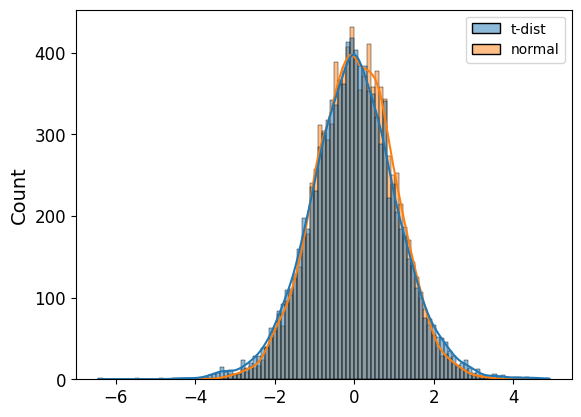

In [ ]:
import seaborn as sns

p = stats.t.rvs(df=10, size=10000)
q = np.random.normal(size=10000)
data = np.c_[p,q]
df = pd.DataFrame(data, columns=["t-dist", "normal"])
sns.histplot(data=df, kde=True, color=['r','b'])

In [ ]:
# ddof (delta degrees of freedom): The divisor used in calculations is N - ddof,
# where N represents the number of elements. By default ddof is zero.

confidence = 0.95
m = len(data)
mean = data.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df = m - 1)  # 0.5 + confidence/2
tmargin = tscore * data.std(ddof=1) / np.sqrt(m)
print("interval by t-score: ", np.sqrt(mean - tmargin), np.sqrt(mean + tmargin))

# by z-score
zscore = stats.norm.ppf((1 + confidence) / 2)   # 0.5 + confidene/2
zmargin = zscore * data.std(ddof=1) / np.sqrt(m)
print("interval by z-score: ", np.sqrt(mean - zmargin), np.sqrt(mean + zmargin))

interval by t-score:  nan 0.16494973438791116
interval by z-score:  nan 0.1649420911545968


<ipython-input-281-ffe5368539ba>:9: RuntimeWarning: invalid value encountered in sqrt
  print("interval by t-score: ", np.sqrt(mean - tmargin), np.sqrt(mean + tmargin))
<ipython-input-281-ffe5368539ba>:14: RuntimeWarning: invalid value encountered in sqrt
  print("interval by z-score: ", np.sqrt(mean - zmargin), np.sqrt(mean + zmargin))


In [ ]:
data.std(ddof=1) / np.sqrt(m), st.sem(data)

(0.010626474855162856, array([0.01119328, 0.01002566]))

## without ColumnTransformer

In [ ]:
X

,city,title,avg_sales,avg_miles
0,London,His Last Bow,270.3,14.2
1,London,How Watson Learned the Trick,370.2,24.1
2,Paris,A Moveable Feast,458.1,15.2
3,Moscow,The Grapes of Wrath,397.4,20.7


In [ ]:
X_num = X[['avg_sales','avg_miles']]
X_cat = X['city']
X_bow = X['title']

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_num_tr = sc.fit_transform(X_num).round(2)

In [ ]:
bow = CountVectorizer()
X_bow_tr = bow.fit_transform(X_bow).toarray()

In [ ]:
ohe = OneHotEncoder()
X_cat_tr = ohe.fit_transform(X_cat.values.reshape(-1,1)).toarray()

In [ ]:
X_num_tr.shape, X_bow_tr.shape, X_cat_tr.shape

In [ ]:
type(X_num_tr), type(X_cat_tr), type(X_bow_tr)

In [ ]:
X_all = np.concatenate([X_num_tr, X_cat_tr, X_bow_tr], axis=1)
X_all

In [ ]:
print(X_num.columns)
print(ohe.get_feature_names())
print(bow.get_feature_names())

In [ ]:
cols = np.r_[X_num.columns, ohe.get_feature_names(), bow.get_feature_names()]
cols

In [ ]:
X_all_df = pd.DataFrame(X_all,
                        columns = cols)
X_all_df

In [ ]:
X_all_df.shape